# Prediction - it's rain or not?

## Imports

In [ ]:
!pip install kneed
!pip install dtaidistance
!pip install fastdtw

In [95]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

if IN_COLAB:
  # Switch to the directory on the Google Drive that you want to use
  import os

  # Mount the Google Drive at mount
  mount='/content/gdrive'
  print("Colab: mounting Google drive on ", mount)
  drive.mount(mount)
  drive_root = mount + "/My Drive/pluie/"

  # Create drive_root if it doesn't exist
  create_drive_root = True
  if create_drive_root:
    print("\nColab: making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)

  # Change to the directory
  print("\nColab: Changing directory to ", drive_root)
  %cd $drive_root

We're running Colab
Colab: mounting Google drive on  /content/gdrive
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

Colab: making sure  /content/gdrive/My Drive/pluie/  exists.

Colab: Changing directory to  /content/gdrive/My Drive/pluie/
/content/gdrive/My Drive/pluie


In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from kneed import KneeLocator

from aing import *
from cfica import *
from clustering import *

import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # default='warn'


## Data Loading

In [4]:
# Replace Pluie by the exact file name Exo_Crews...
data=pd.read_csv("Douala/CML_Douala/L1_172.22.204.1P4.1-172.22.204.6P4.1_29A-B.csv",sep=";", parse_dates=['datetime'])

# verify your number of observations and columns
# change separator if needed ',' or '\t' ...
print(data.shape[0], "observations (lines) by ", data.shape[1], "features (columns)")



39456 observations (lines) by  17 features (columns)


## Data exploration

In [5]:
data.head(5)


,datetime,direction,unique_link_id,length,frequency,TSL_min,TSL_mean,TSL_max,RSL_min,RSL_mean,RSL_max,Rgage,gage,dist_lnk_gage,link_name,calc_coeff_a,calc_coeff_b
0,2018-06-06 00:05:00,29 A-B,172.22.204.1P4.1-172.22.204.6P4.1,1.51,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Meteo_IUT,0.413045,1G_MPR_NDOGBONG_1 - MPR_ANGERAPHAEL,0.0473,1.1022
1,2018-06-06 00:20:00,29 A-B,172.22.204.1P4.1-172.22.204.6P4.1,1.51,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Meteo_IUT,0.413045,1G_MPR_NDOGBONG_1 - MPR_ANGERAPHAEL,0.0473,1.1022
2,2018-06-06 00:35:00,29 A-B,172.22.204.1P4.1-172.22.204.6P4.1,1.51,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Meteo_IUT,0.413045,1G_MPR_NDOGBONG_1 - MPR_ANGERAPHAEL,0.0473,1.1022
3,2018-06-06 00:50:00,29 A-B,172.22.204.1P4.1-172.22.204.6P4.1,1.51,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Meteo_IUT,0.413045,1G_MPR_NDOGBONG_1 - MPR_ANGERAPHAEL,0.0473,1.1022
4,2018-06-06 01:05:00,29 A-B,172.22.204.1P4.1-172.22.204.6P4.1,1.51,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Meteo_IUT,0.413045,1G_MPR_NDOGBONG_1 - MPR_ANGERAPHAEL,0.0473,1.1022


In [6]:
data.tail(5)

,datetime,direction,unique_link_id,length,frequency,TSL_min,TSL_mean,TSL_max,RSL_min,RSL_mean,RSL_max,Rgage,gage,dist_lnk_gage,link_name,calc_coeff_a,calc_coeff_b
39451,2019-12-31 22:52:00,29 A-B,172.22.204.1P4.1-172.22.204.6P4.1,1.51,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Meteo_IUT,0.413045,1G_MPR_NDOGBONG_1 - MPR_ANGERAPHAEL,0.0473,1.1022
39452,2019-12-31 23:07:00,29 A-B,172.22.204.1P4.1-172.22.204.6P4.1,1.51,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Meteo_IUT,0.413045,1G_MPR_NDOGBONG_1 - MPR_ANGERAPHAEL,0.0473,1.1022
39453,2019-12-31 23:22:00,29 A-B,172.22.204.1P4.1-172.22.204.6P4.1,1.51,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Meteo_IUT,0.413045,1G_MPR_NDOGBONG_1 - MPR_ANGERAPHAEL,0.0473,1.1022
39454,2019-12-31 23:37:00,29 A-B,172.22.204.1P4.1-172.22.204.6P4.1,1.51,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Meteo_IUT,0.413045,1G_MPR_NDOGBONG_1 - MPR_ANGERAPHAEL,0.0473,1.1022
39455,2019-12-31 23:52:00,29 A-B,172.22.204.1P4.1-172.22.204.6P4.1,1.51,14.5,4.0,4.0,4.0,-43.0,-43.0,-43.0,NaN,Meteo_IUT,0.413045,1G_MPR_NDOGBONG_1 - MPR_ANGERAPHAEL,0.0473,1.1022


In [7]:
# detection of Meta-Data
# a Meta-data could be a unique value, or reduced number (Quality code)
metaValue = 1
card = []
for i in range(data.shape[1]):
    card.append(len(data.iloc[:, i].unique()))

# extraction of non Meta information
subset = np.array(card) > metaValue
df = data.loc[:, subset]

print(df.head(n=3))
print("...")
print(df.tail(n=2))


             datetime  TSL_min  TSL_mean  TSL_max  RSL_min  RSL_mean  RSL_max  \
0 2018-06-06 00:05:00      NaN       NaN      NaN      NaN       NaN      NaN   
1 2018-06-06 00:20:00      NaN       NaN      NaN      NaN       NaN      NaN   
2 2018-06-06 00:35:00      NaN       NaN      NaN      NaN       NaN      NaN   

   Rgage  
0    NaN  
1    NaN  
2    NaN  
...
                 datetime  TSL_min  TSL_mean  TSL_max  RSL_min  RSL_mean  \
39454 2019-12-31 23:37:00      NaN       NaN      NaN      NaN       NaN   
39455 2019-12-31 23:52:00      4.0       4.0      4.0    -43.0     -43.0   

       RSL_max  Rgage  
39454      NaN    NaN  
39455    -43.0    NaN  


In [8]:
# date identification
df.loc[:, 'datetime']=pd.to_datetime(df.loc[:,"datetime"], format="%Y-%m-%d %H:%M:%S")
df.set_index("datetime", inplace=True)
df.loc[:, 'TRSL_mean'] = df.copy()['RSL_mean'] - df.copy()['TSL_mean']

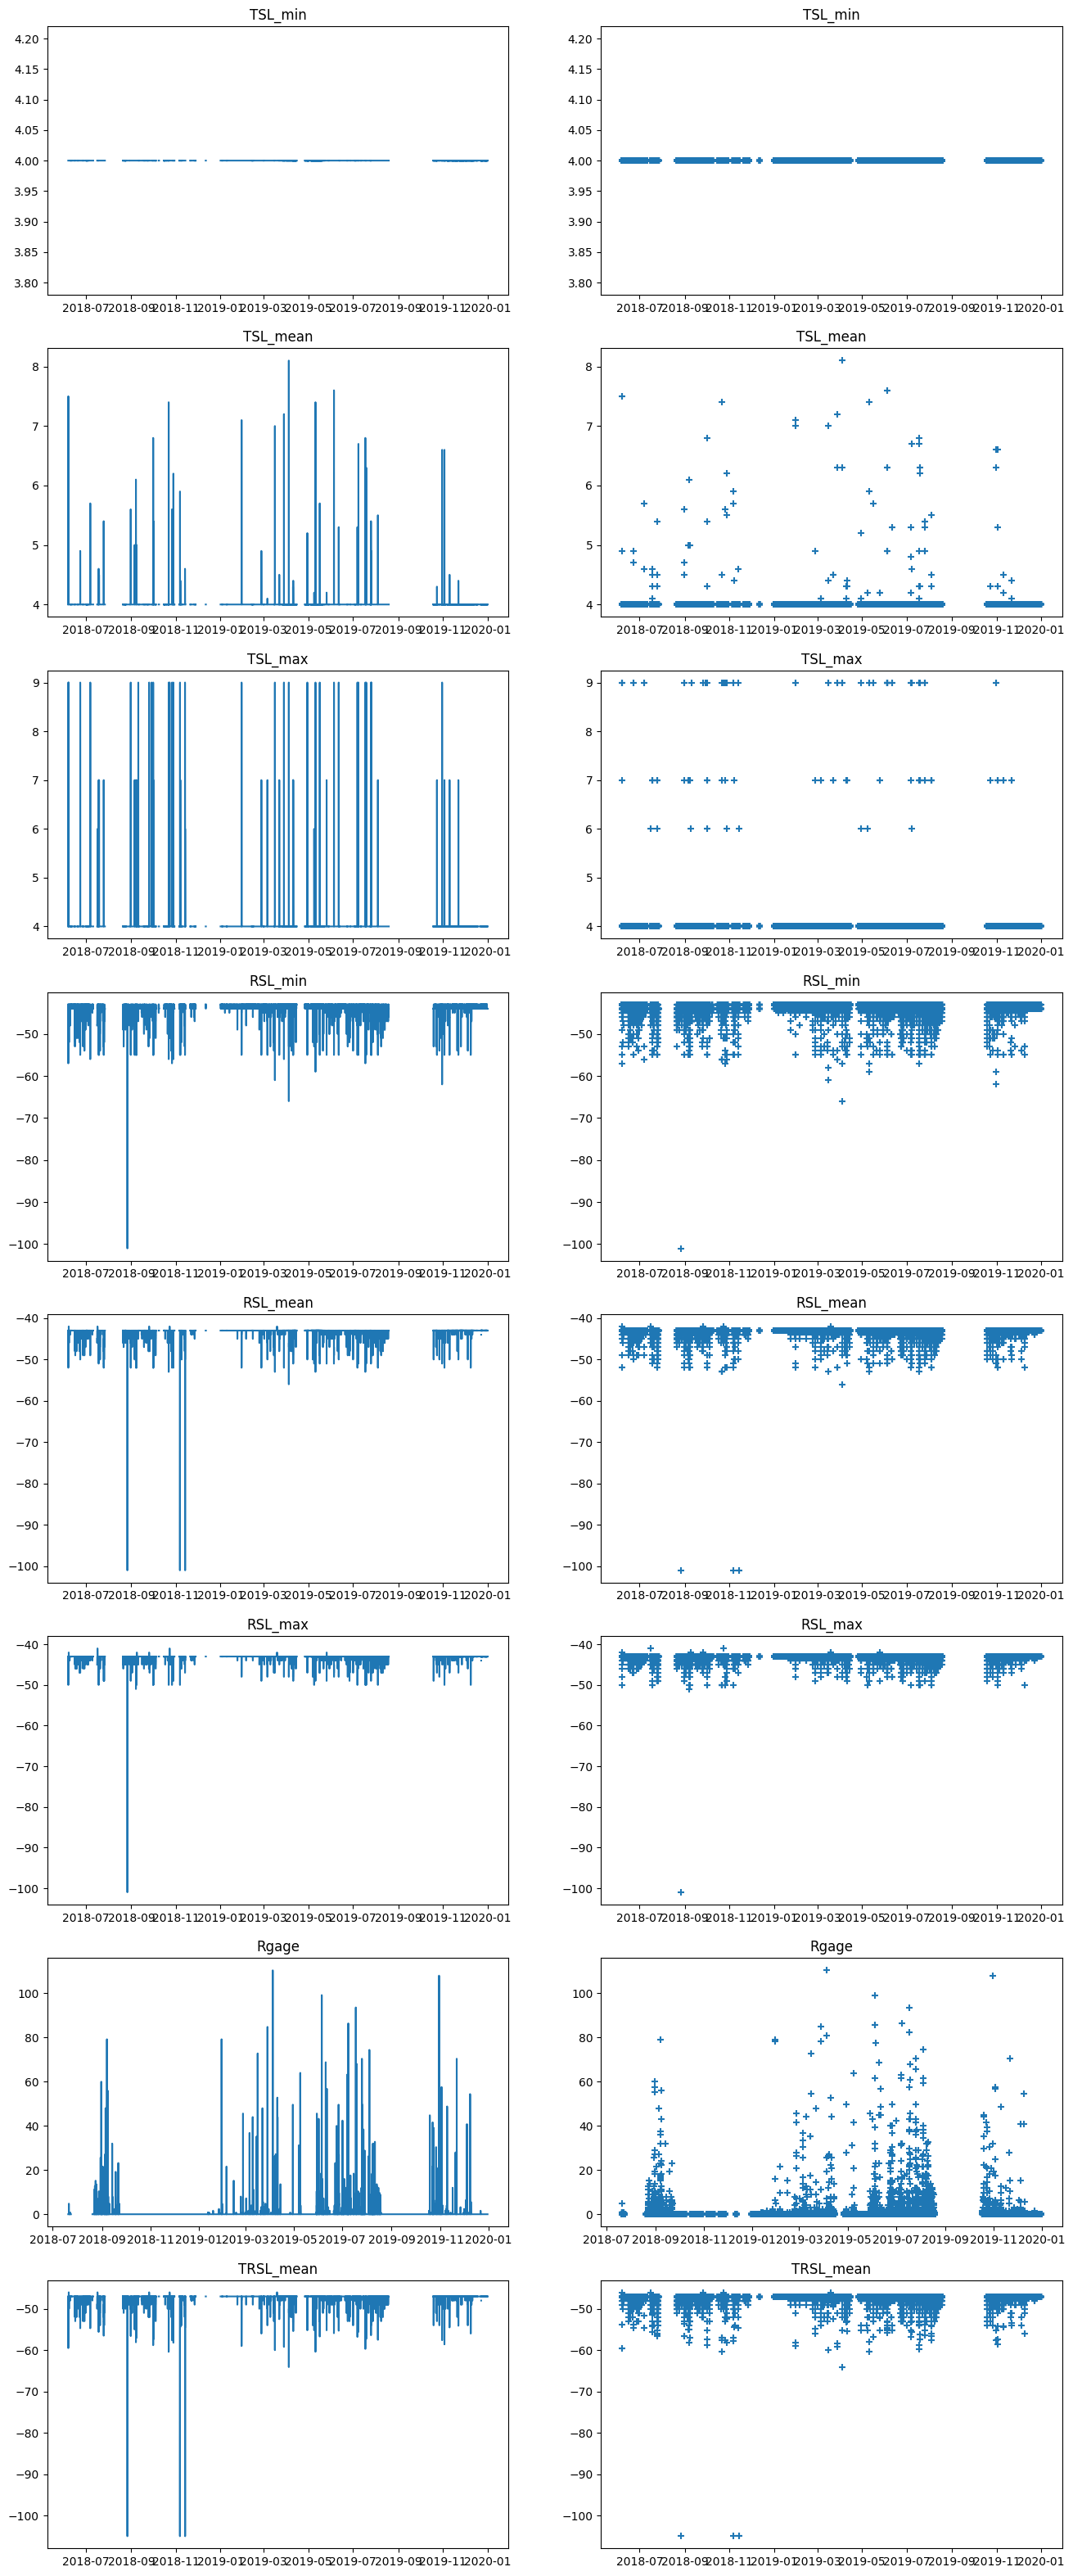

In [9]:
fig, axs = plt.subplots(len(df.columns), 2, figsize=(16, 5 * len(df.columns)))

for i, col in enumerate(df.columns):
    axs[i, 0].plot(df[col])
    axs[i, 0].set_title(col)
    axs[i, 1].scatter(df.index, df[col], marker='+')
    axs[i, 1].set_title(col)

plt.show()


In [10]:
# correlation information
df.corr().round(2)

,TSL_min,TSL_mean,TSL_max,RSL_min,RSL_mean,RSL_max,Rgage,TRSL_mean
TSL_min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TSL_mean,NaN,1.00,0.81,-0.39,-0.33,-0.29,0.34,-0.41
TSL_max,NaN,0.81,1.00,-0.45,-0.37,-0.32,0.38,-0.43
RSL_min,NaN,-0.39,-0.45,1.00,0.71,0.75,-0.45,0.72
RSL_mean,NaN,-0.33,-0.37,0.71,1.00,0.77,-0.34,1.00
RSL_max,NaN,-0.29,-0.32,0.75,0.77,1.00,-0.34,0.77
Rgage,NaN,0.34,0.38,-0.45,-0.34,-0.34,1.00,-0.36
TRSL_mean,NaN,-0.41,-0.43,0.72,1.00,0.77,-0.36,1.00


## Identification of Pattern by unsupervised approach

In [11]:
#remove observations with NA information
df.dropna(inplace=True)
df.describe()


,TSL_min,TSL_mean,TSL_max,RSL_min,RSL_mean,RSL_max,Rgage,TRSL_mean
count,34302.0,34302.000000,34302.000000,34302.000000,34302.000000,34302.000000,34302.000000,34302.000000
mean,4.0,4.003326,4.010991,-43.744038,-43.143869,-43.105562,0.373879,-47.147195
std,0.0,0.085244,0.214681,1.179975,0.903737,0.567703,3.383362,0.934710
min,4.0,4.000000,4.000000,-101.000000,-101.000000,-101.000000,0.000000,-105.000000
25%,4.0,4.000000,4.000000,-44.000000,-43.000000,-43.000000,0.000000,-47.000000
50%,4.0,4.000000,4.000000,-44.000000,-43.000000,-43.000000,0.000000,-47.000000
75%,4.0,4.000000,4.000000,-43.000000,-43.000000,-43.000000,0.000000,-47.000000
max,4.0,8.100000,9.000000,-43.000000,-42.000000,-41.000000,110.400000,-46.000000


In [12]:

# Normalisation

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(df.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled.index = df.index
df_scaled.head()

,TSL_min,TSL_mean,TSL_max,RSL_min,RSL_mean,RSL_max,Rgage,TRSL_mean
datetime,,,,,,,,
2018-07-20 12:35:00,0.0,-0.039022,-0.051196,-0.216925,0.159196,0.185949,-0.110507,0.157479
2018-07-20 12:50:00,0.0,-0.039022,-0.051196,0.630564,0.159196,0.185949,-0.110507,0.157479
2018-07-20 13:05:00,0.0,-0.039022,-0.051196,0.630564,0.159196,0.185949,-0.110507,0.157479
2018-07-20 13:20:00,0.0,-0.039022,-0.051196,-0.216925,0.159196,0.185949,-0.110507,0.157479
2018-07-20 13:35:00,0.0,-0.039022,-0.051196,-0.216925,0.159196,0.185949,-0.110507,0.157479


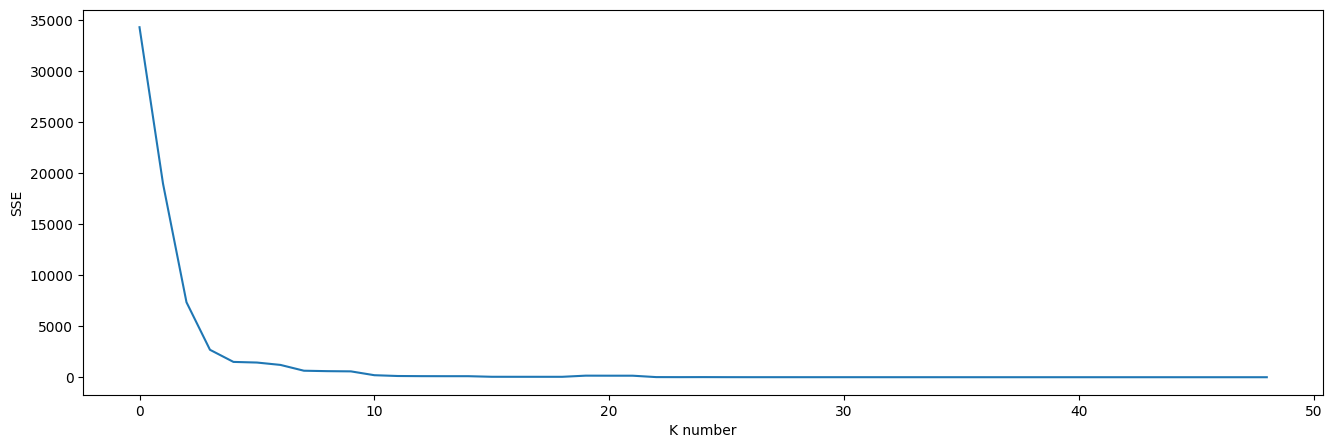

The optimal value of k is: 5


In [13]:
#File 1 identify pattern structure without temporal information
sse = []
Kmax = 50
for k in range(1, Kmax):
    kmeans = KMeans(init = "random", n_clusters = k, n_init = 10, max_iter=300, random_state = 42)
    kmeans.fit(df_scaled[['TRSL_mean']])
    sse.append(kmeans.inertia_)
plt.figure(figsize= (16,5))
plt.xlabel("K number")
plt.ylabel("SSE")
plt.plot(sse)
plt.show()
kl = KneeLocator(range(1, Kmax), sse, curve="convex", direction="decreasing")
print(f"The optimal value of k is: {kl.elbow}")


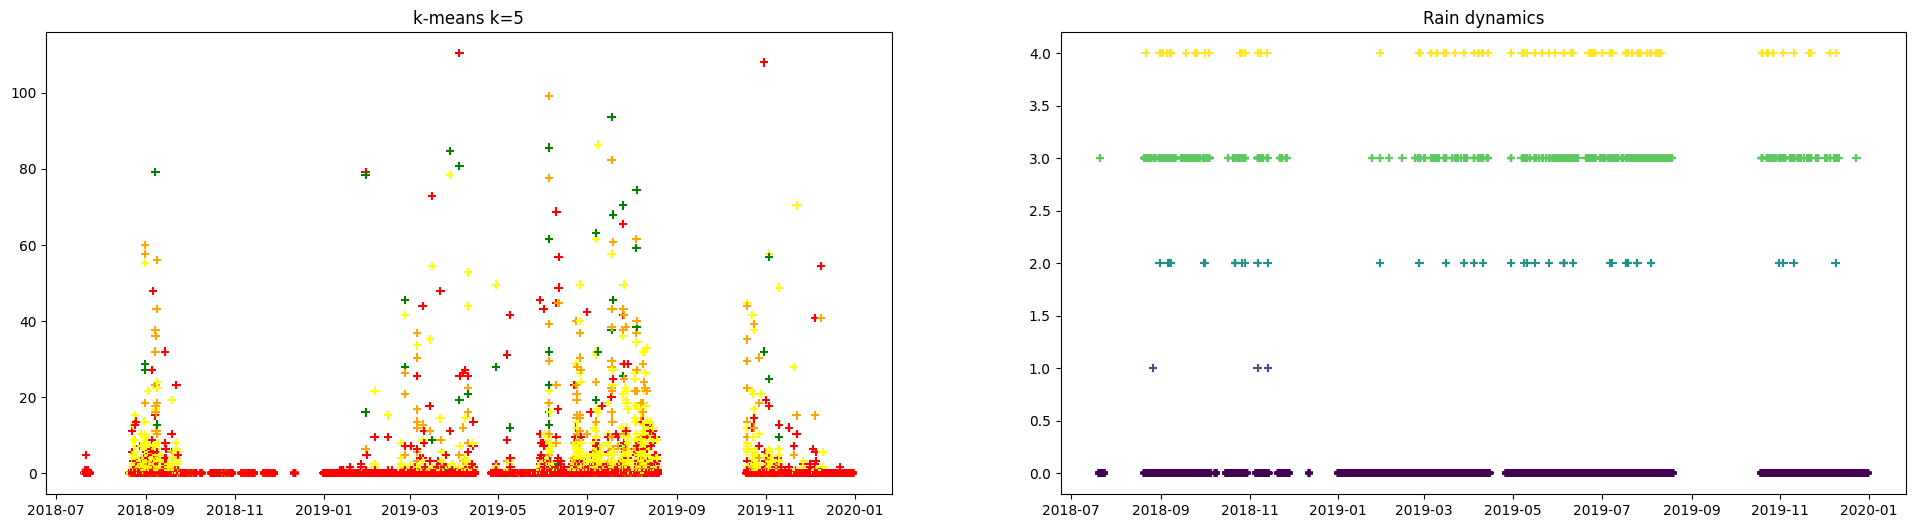

In [14]:
km1 = KMeans(init="random", n_clusters=5, n_init=10, max_iter=300, random_state=42)
km1.fit(df_scaled.loc[:, ['TRSL_mean']])

fig, axs = plt.subplots(1, 2, figsize=(24, 6))
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'black', 'cyan', 'magenta', 'grey']
axs[0].scatter(df_scaled.index, df['Rgage'], c=[colors[i] for i in km1.labels_], marker='+')
axs[0].set_title(f"k-means k={kl.elbow}", fontdict={"fontsize": 12})

axs[1].scatter(df_scaled.index, km1.labels_, c=km1.labels_, marker='+')
axs[1].set_title("Rain dynamics")

plt.show()


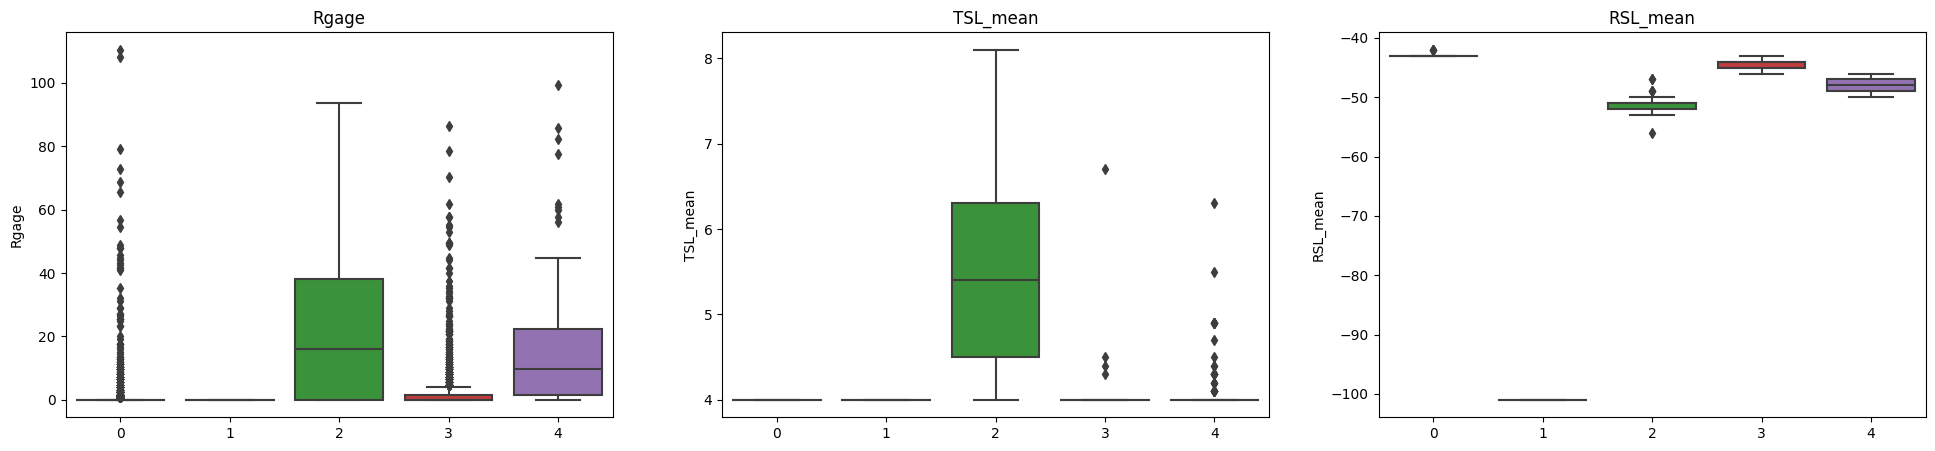

In [15]:
labels = km1.labels_

fig, axs = plt.subplots(1, 3, figsize=(24, 5))

sns.boxplot(y=df.Rgage, x=labels, ax=axs[0])
axs[0].set_title("Rgage")

sns.boxplot(y=df.TSL_mean, x=labels, ax=axs[1])
axs[1].set_title("TSL_mean")

sns.boxplot(y=df.RSL_mean, x=labels, ax=axs[2])
axs[2].set_title("RSL_mean")

plt.show()


# Incremental Clustering

In [16]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colors = list(colors.keys())

def plot_data(df, y, labels, title):
    fig, axs = plt.subplots(1, 2, figsize=(24, 5))
    # plot the clusters and the centroids

    axs[0].scatter(df.index, y, c=[colors[i] for i in labels], marker='+')
    axs[0].set_xlabel("DateTime")
    axs[0].set_ylabel("Rain Gauge - RGage")
    axs[0].set_title(title)
    axs[1].scatter(df.index, labels, c=[colors[i] for i in labels], marker='+')
    axs[1].set_title("Labels")
    axs[1].set_xlabel("DateTime")
    axs[1].set_ylabel("labels")
    plt.show()


In [17]:
#X=df_scaled.drop(['Rgage', 'TSL_mean', 'RSL_mean'],axis=1)
X = df_scaled.loc[:, ['TRSL_mean']]
y=df_scaled.Rgage



In [18]:
cfica = CFICA(X.values, 200, 100, 1, 1.4)
cfica.fit()
labels2 = cfica.labels

Number of clusters:  2
Labels:  (array([0, 1]), array([196,   4]))
After merging:  1
After merging:  3
After merging:  2
After merging:  4
After merging:  3
After merging:  4
After merging:  3
After merging:  5
After merging:  4
After merging:  3
After merging:  4
After merging:  3
After merging:  3
After merging:  5
After merging:  4
After merging:  5
After merging:  4
After merging:  9
After merging:  8
After merging:  7
After merging:  6
After merging:  8
After merging:  7
After merging:  6
After merging:  7
After merging:  6
After merging:  6
After merging:  7
After merging:  6
After merging:  8
After merging:  7
After merging:  6
After merging:  9
After merging:  8
After merging:  7
After merging:  11
After merging:  10
After merging:  9
After merging:  8
After merging:  10
After merging:  9
After merging:  8
After merging:  9
After merging:  8
After merging:  9
After merging:  8
After merging:  8
After merging:  8
After merging:  8
After merging:  8
After merging:  9
After mergin

In [20]:
clustering =  ProposedApproach(X.values, 200, 100, 0.1, 0.5)
clustering.fit()
clustering.cluster_outliers()
labels1 = clustering.labels

new cluster
new cluster
Clustering outliers
new cluster
new cluster
new cluster
new cluster
After merging:  7
After merging:  6
After merging:  5
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
After merging:  13
new cluster


In [ ]:
aing = AING(5)
aing.fit(X.values)
print("Len of the graph: ", len(aing.G))
point_to_neuron = {}
somme = 0
for i in range(len(aing.G)):
    # Handle points assigned to neuron i
    for point in aing.G[i]['points']:
        point_to_neuron[tuple(point)] = i
        somme += 1

    # Handle centroid of neuron i
    centroid = aing.G[i]['w']
    somme += 1
    point_to_neuron[tuple(centroid)] = i

labels3 = [point_to_neuron[tuple(point)] for point in X.values]



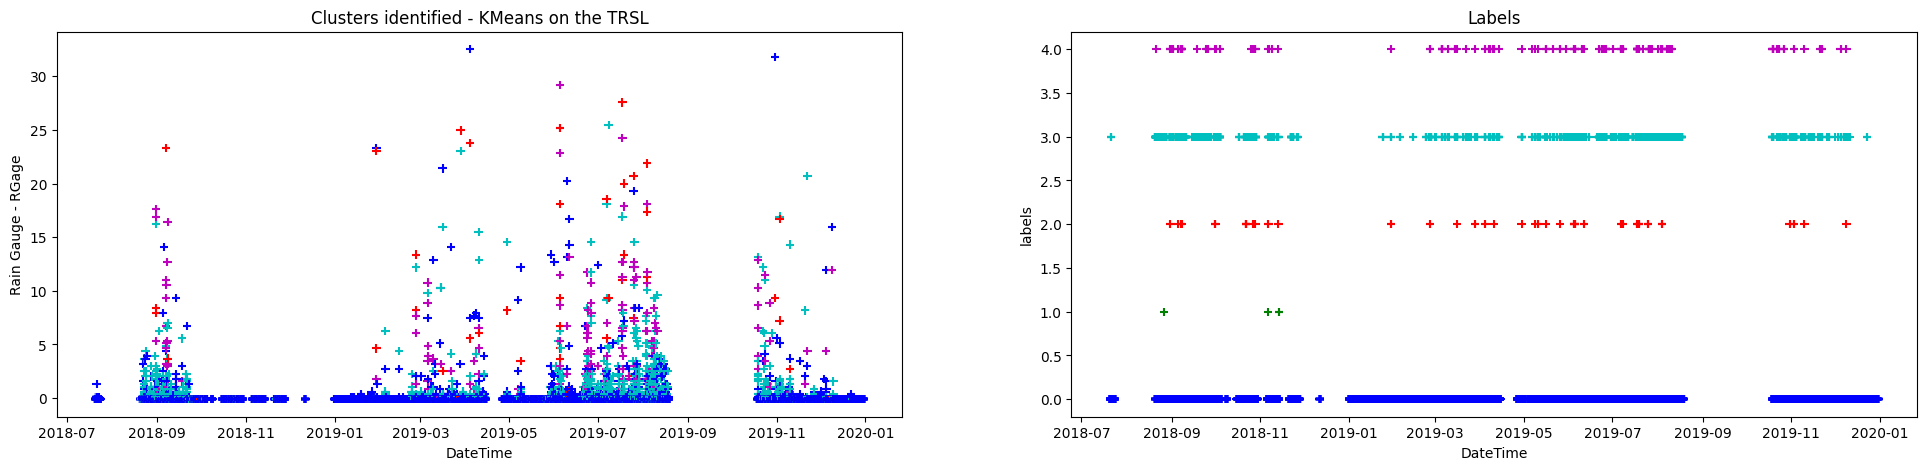

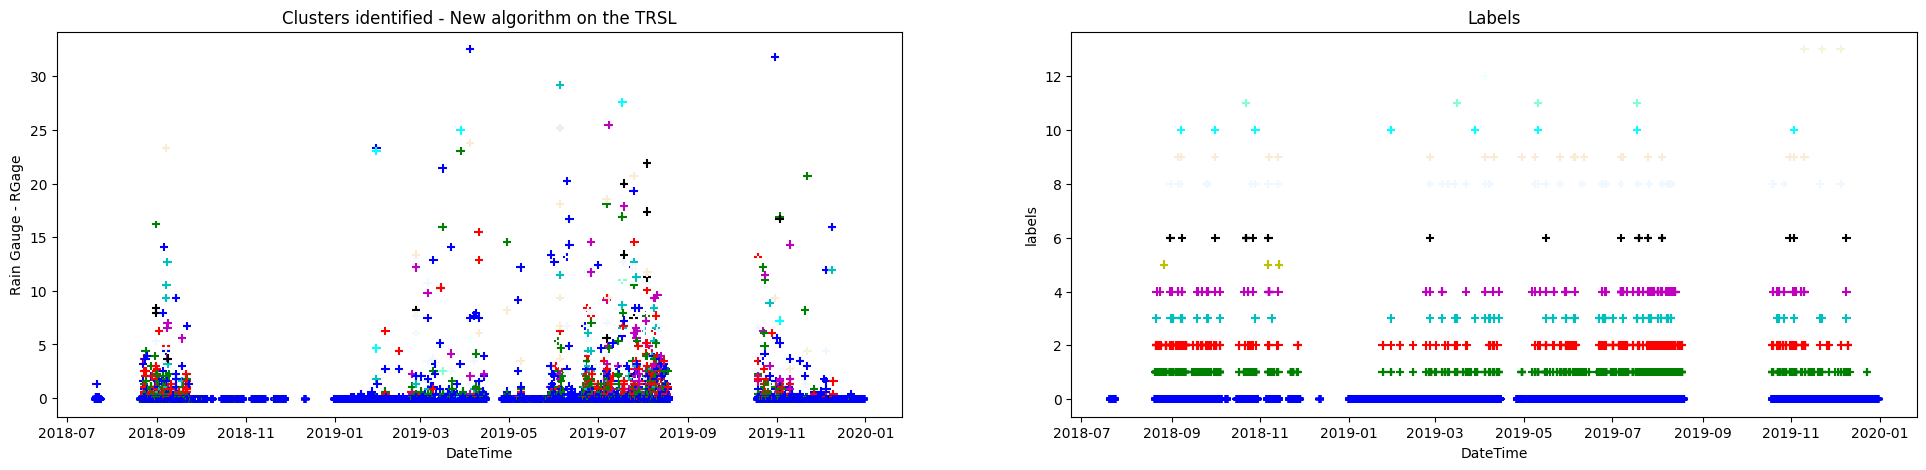

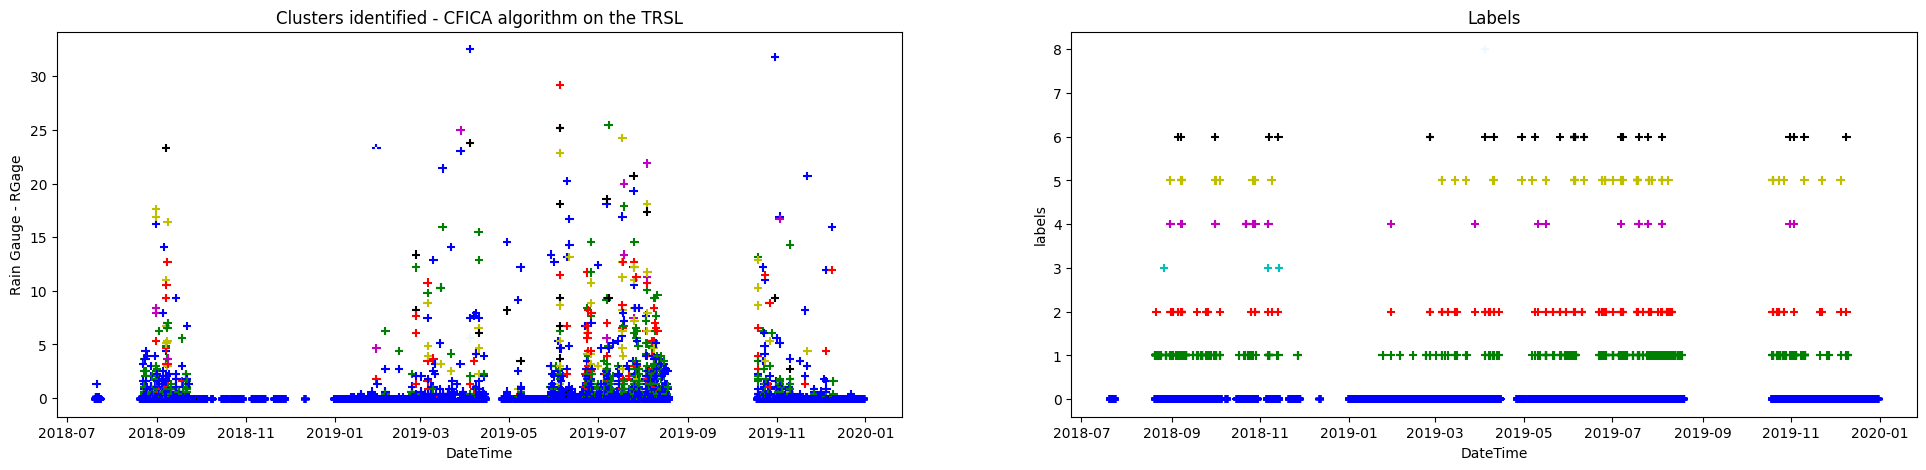

In [21]:
plot_data(df, y, km1.labels_, "Clusters identified - KMeans on the TRSL")
plot_data(df, y, labels1, "Clusters identified - New algorithm on the TRSL")
plot_data(df, y, labels2, "Clusters identified - CFICA algorithm on the TRSL")
# plot_data(df, y, labels3, "Clusters identified - AING algorithm on the TRSL")



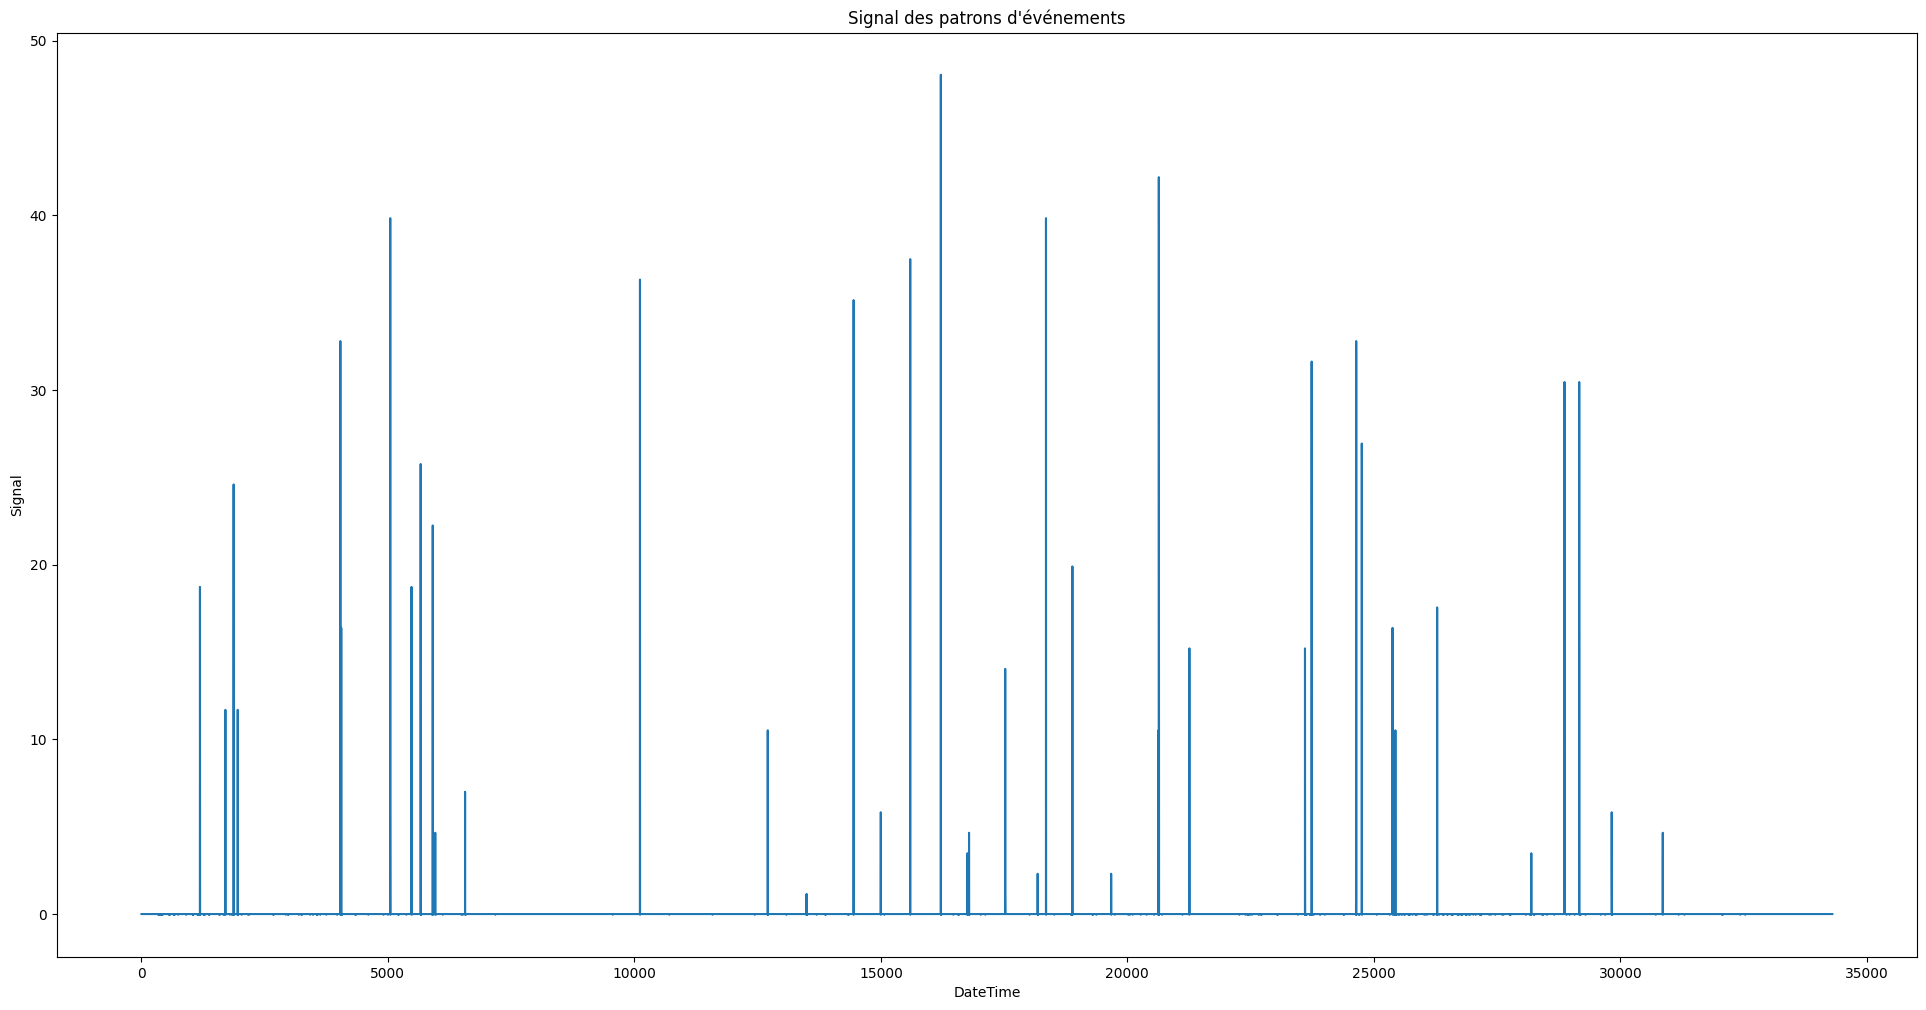

In [38]:
plt.figure(figsize=(24, 12))
# Créer une liste pour stocker les données du signal
signal = []

# Parcourir les données des labels
for i in range(len(labels2)):
    # Si le label change de 0 vers un autre label
    if i > 0 and labels2[i] != 0:
        # Ajouter l'amplitude correspondante dans la colonne TSL_mean au signal
        signal.append(df_scaled['TSL_mean'].iloc[i])
    else:
        # Sinon, ajouter 0 au signal
        signal.append(0)

# Créer un graphique en utilisant les données du signal
plt.plot(signal)
plt.xlabel('DateTime')
plt.ylabel('Signal')
plt.title('Signal des patrons d\'événements')
plt.show()



In [27]:
# Créer un nouveau DataFrame pour stocker les données des événements de pluie
rain_events = pd.DataFrame(columns=['Event', 'Amplitudes'])

# Initialiser les variables pour stocker les données des événements de pluie
event = 0
amplitudes = []

# Parcourir les données des labels
for i in range(len(labels2)):
    # Si le label change de 0 vers un autre label
    if i > 0 and labels2[i] != 0:
        # Ajouter l'amplitude correspondante dans la colonne TSL_mean aux amplitudes de l'événement en cours
        amplitudes.append(df['TSL_mean'].iloc[i])
    else:
        # Si les amplitudes de l'événement en cours ne sont pas vides
        if len(amplitudes) > 0:
            # Vérifier si les labels suivants sont également 0
            next_labels_zero = True
            for j in range(i, min(i+10, len(labels2))):
                if labels2[j] != 0:
                    next_labels_zero = False
                    break
            # Si les labels suivants sont également 0
            if next_labels_zero:
                # Ajouter les données de l'événement en cours au DataFrame
                rain_events.loc[event] = [event, amplitudes]
                # Réinitialiser les variables pour le prochain événement
                event += 1
                amplitudes = []

# Afficher la table des événements de pluie
display(rain_events)



,Event,Amplitudes
0,0,[-0.03902185713147156]
1,1,"[-0.03902185713147156, -0.03902185713147156, -..."
2,2,"[-0.03902185713147156, -0.03902185713147156, -..."
3,3,"[-0.03902185713147156, -0.03902185713147156, -..."
4,4,"[-0.03902185713147156, -0.03902185713147156, -..."
...,...,...
178,178,"[-0.03902185713147156, -0.03902185713147156]"
179,179,"[-0.03902185713147156, -0.03902185713147156, -..."
180,180,[-0.03902185713147156]
181,181,"[-0.03902185713147156, -0.03902185713147156, -..."


In [49]:
# Create a new DataFrame to store the data for the non-rain events
non_rain_events = pd.DataFrame(columns=['Event', 'Amplitudes'])

# Initialize the variables to store the data for the non-rain events
event = 0
amplitudes = []

# Iterate over the data from the labels
for i in range(len(labels2)):
    # If the label is 0 (i.e., no rain)
    if labels2[i] == 0:
        # Add the corresponding amplitude from the TSL_mean column to the amplitudes of the current event
        amplitudes.append(df['TSL_mean'].iloc[i])
    else:
        # If the amplitudes of the current event are not empty and have a length of at least 10
        if len(amplitudes) > 10:
            # Add the data for the current event to the DataFrame
            non_rain_events.loc[event] = [event, amplitudes]
            # Reset the variables for the next event
            event += 1
            amplitudes = []

display(non_rain_events)


,Event,Amplitudes
0,0,"[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, ..."
1,1,"[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, ..."
2,2,"[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, ..."
3,3,"[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, ..."
4,4,"[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, ..."
...,...,...
179,179,"[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, ..."
180,180,"[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, ..."
181,181,"[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, ..."
182,182,"[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, ..."


In [50]:
# Find the maximum length of the amplitudes
max_length = non_rain_events['Amplitudes'].str.len().max()

# Create a new DataFrame with separate columns for each amplitude
non_rain_events_sep = pd.DataFrame(columns=['Event'] + [f'a{i+1}' for i in range(max_length)])

# Iterate over the data from the non-rain events
for i, row in non_rain_events.iterrows():
    # Add the data for the event to the DataFrame
    non_rain_events_sep.loc[i, 'Event'] = row['Event']
    for j, amp in enumerate(row['Amplitudes']):
        non_rain_events_sep.loc[i, f'a{j+1}'] = amp

# Replace missing values with 0
non_rain_events_sep.fillna(0, inplace=True)

# Save the DataFrame to a CSV file
non_rain_events_sep.to_csv('non_rain_events_sep.csv', index=False)


In [74]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import numpy as np

# Select the columns containing the amplitudes
amplitude_cols = [col for col in non_rain_events_sep.columns if col.startswith('a')]

# Extract the amplitude data and convert it to arrays of type array, only including rows that have the correct shape
amplitude_data = [row for row in non_rain_events_sep[amplitude_cols].values if row.ndim == 1]

# Calculate the DTW distance matrix using FastDTW
dist_matrix = np.array([[fastdtw(x.reshape(1,-1), y.reshape(1, -1), dist=euclidean)[0] for y in amplitude_data] for x in amplitude_data])

# Create a DataFrame to store the distance matrix
distance_matrix_nrevents = pd.DataFrame(dist_matrix, columns=non_rain_events_sep['Event'], index=non_rain_events_sep['Event'])

# Display the distance matrix
display(distance_matrix_nrevents)


Event,0,1,2,3,4,5,6,7,8,9,...,174,175,176,177,178,179,180,181,182,183
Event,,,,,,,,,,,,,,,,,,,,,
0,0.000000,72.663608,72.443081,71.665891,56.709788,63.749510,72.443081,66.211781,53.516353,58.240879,...,63.498031,58.103356,92.520268,56.568542,19.183326,59.732738,81.584312,71.888803,12.649111,62.609903
1,72.663608,0.000000,5.656854,12.000000,45.431267,34.871192,5.656854,29.933259,49.152823,43.451122,...,35.327043,43.634848,117.643529,45.607017,70.085662,41.376322,109.252002,10.583005,73.756356,36.878178
2,72.443081,5.656854,0.000000,10.583005,45.077711,34.409301,0.000000,29.393877,48.826222,43.081318,...,34.871192,43.266615,117.507447,45.254834,69.856997,40.987803,109.105454,8.944272,73.539105,36.441734
3,71.665891,12.000000,10.583005,0.000000,43.817805,32.741411,10.583005,27.422618,47.665501,41.761226,...,33.226495,41.952354,117.029911,44.000000,69.050706,39.597980,108.590976,5.656854,72.773622,34.871192
4,56.709788,45.431267,45.077711,43.817805,0.000000,29.120440,45.077711,34.176015,18.761663,13.266499,...,28.565714,12.649111,108.517280,4.000000,53.366656,18.761663,99.357939,44.181444,58.103356,26.532998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,59.732738,41.376322,40.987803,39.597980,18.761663,22.271057,40.987803,28.565714,26.532998,13.266499,...,21.540659,13.856406,110.127199,19.183326,56.568542,0.000000,101.113797,40.000000,61.057350,18.761663
180,81.584312,109.252002,109.105454,108.590976,99.357939,103.537433,109.105454,105.071404,97.570487,100.239713,...,103.382784,100.159872,43.634848,99.277389,83.809307,101.113797,0.000000,108.738218,80.597767,102.839681
181,71.888803,10.583005,8.944272,5.656854,44.181444,33.226495,8.944272,28.000000,48.000000,42.142615,...,33.704599,42.332021,117.166548,44.362146,69.282032,40.000000,108.738218,0.000000,72.993150,35.327043


In [76]:
from sklearn.preprocessing import MinMaxScaler

# Flatten the distance matrix into a 1D array
distances = distance_matrix_nrevents.values.flatten()

# Create a MinMaxScaler object to scale the distances
scaler = MinMaxScaler()

# Scale the distances using min-max normalization
scaled_distances = scaler.fit_transform(distances.reshape(-1, 1)).flatten()

# Reshape the scaled distances back into a matrix
scaled_distances_matrix = pd.DataFrame(scaled_distances.reshape(distance_matrix_nrevents.shape), columns=distance_matrix_nrevents.columns, index=distance_matrix_nrevents.index)

# Display the scaled distance matrix
display(scaled_distances_matrix)

silhouette_scores = []
k_range = range(7, 15)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_distances_matrix)
    score = silhouette_score(scaled_distances_matrix, labels)
    silhouette_scores.append(score)
# Find the optimal number of clusters based on the highest silhouette score
k = k_range[np.argmax(silhouette_scores)]
# Create a KMeans object with the desired number of clusters
kmeans = KMeans(n_clusters=k)

# Fit the K-means algorithm to the distance matrix
kmeans.fit(scaled_distances_matrix)

# Get the cluster labels for each event
labels = kmeans.labels_

# Display the cluster labels
print(labels)


Event,0,1,2,3,4,5,6,7,8,9,...,174,175,176,177,178,179,180,181,182,183
Event,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.373386,0.372253,0.368259,0.291406,0.327580,0.372253,0.340233,0.274997,0.299274,...,0.326288,0.298567,0.475420,0.290680,0.098575,0.306940,0.419225,0.369404,0.064998,0.321724
1,0.373386,0.000000,0.029068,0.061663,0.233451,0.179187,0.029068,0.153814,0.252574,0.223276,...,0.181530,0.224220,0.604518,0.234354,0.360139,0.212614,0.561397,0.054381,0.379001,0.189500
2,0.372253,0.029068,0.000000,0.054381,0.231634,0.176814,0.000000,0.151042,0.250896,0.221376,...,0.179187,0.222328,0.603818,0.232544,0.358964,0.210618,0.560644,0.045961,0.377885,0.187258
3,0.368259,0.061663,0.054381,0.000000,0.225160,0.168243,0.054381,0.140913,0.244932,0.214592,...,0.170736,0.215574,0.601364,0.226096,0.354821,0.203476,0.558001,0.029068,0.373951,0.179187
4,0.291406,0.233451,0.231634,0.225160,0.000000,0.149637,0.231634,0.175615,0.096408,0.068171,...,0.146786,0.064998,0.557622,0.020554,0.274227,0.096408,0.510556,0.227029,0.298567,0.136341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,0.306940,0.212614,0.210618,0.203476,0.096408,0.114441,0.210618,0.146786,0.136341,0.068171,...,0.110688,0.071202,0.565895,0.098575,0.290680,0.000000,0.519579,0.205542,0.313746,0.096408
180,0.419225,0.561397,0.560644,0.558001,0.510556,0.532033,0.560644,0.539915,0.501371,0.515087,...,0.531238,0.514677,0.224220,0.510142,0.430659,0.519579,0.000000,0.558757,0.414156,0.528447
181,0.369404,0.054381,0.045961,0.029068,0.227029,0.170736,0.045961,0.143879,0.246651,0.216552,...,0.173193,0.217525,0.602067,0.227957,0.356009,0.205542,0.558757,0.000000,0.375079,0.181530


[ 8  9  9  9  0 12  9  6 10  0  9  6  2  9  6 12 10  6  9  9 12  2  2  6
  6  0 13  5 11  5 11 10 11  6 11  0  5  6  9  5  9  5  8 12 11 10 10 12
 10  5 11  0  1  2 11  9  7  3  7  7  4  4  5  1  1 10 10 13  9 12  7  6
 13  7  5 12 10  2  5 12  1 13 10 10 10  8  9  1  6  8  6  5  2 11 10  0
  0 12 11  1  0  4  0  2  2  2  0  2  9  8  1  0  6  2  2  0 12  1  5 11
 11  8  5 11  2  9  2  9  2 11  6  9 11 11  2  0  2  0  6  2  6  9  6  6
 12 11  9  6 11  2  6 11 12  9 10  2 12  0  2  0  8  6  2 11 10 12  0 10
  2  6 12 12 12  8 12  0  4  0  8  0  4  9  8 12]


In [110]:
import os
import pandas as pd
from cfica import *

# Set the path to the data folder
data_folder = 'Douala/CML_Douala/'

# Create an empty list to store the rain events from each file
all_rain_events = []

# Iterate over the files in the data folder
for filename in os.listdir(data_folder):
    # Check if the file is a CSV file
    if filename.endswith('.csv'):
        # Read in the data from the CSV file
        data = pd.read_csv(os.path.join(data_folder, filename), sep=';', parse_dates=['datetime'])
        metaValue = 1
        card = []
        for i in range(data.shape[1]):
            card.append(len(data.iloc[:, i].unique()))

        # extraction of non Meta information
        subset = np.array(card) > metaValue
        df = data.loc[:, subset]

        # date identification
        df.loc[:, 'datetime']=pd.to_datetime(df.loc[:,"datetime"], format="%Y-%m-%d %H:%M:%S")
        df.set_index("datetime", inplace=True)
        df.loc[:, 'TRSL_mean'] = df.copy()['RSL_mean'] - df.copy()['TSL_mean']

        #remove observations with NA information
        df.dropna(inplace=True)

        # Normalisation

        from sklearn.preprocessing import StandardScaler
        std_scaler = StandardScaler()
        df_scaled = std_scaler.fit_transform(df.to_numpy())
        df_scaled = pd.DataFrame(df_scaled, columns=df.columns)


        # Process the data to find the rain events (same as in your previous code)
        X=df_scaled.drop(['Rgage', 'TSL_mean', 'RSL_mean'],axis=1)
        y=df_scaled.Rgage

        clustering =  ProposedApproach(X.values, 1200, 100, 4, 1)
        clustering.fit()
        clustering.cluster_outliers()
        labels1 = clustering.labels

        # Créer un nouveau DataFrame pour stocker les données des événements de pluie
        rain_events = pd.DataFrame(columns=['Event', 'Amplitudes'])

        # Initialiser les variables pour stocker les données des événements de pluie
        event = 0
        amplitudes = []

        # Parcourir les données des labels
        for i in range(len(labels1)):
            # Si le label change de 0 vers un autre label
            if i > 0 and labels1[i] != 0:
                # Ajouter l'amplitude correspondante dans la colonne TSL_mean aux amplitudes de l'événement en cours
                amplitudes.append(df['TSL_mean'].iloc[i])
            else:
                # Si les amplitudes de l'événement en cours ne sont pas vides
                if len(amplitudes) > 0:
                    # Vérifier si les labels suivants sont également 0
                    next_labels_zero = True
                    for j in range(i, min(i+10, len(labels1))):
                        if labels1[j] != 0:
                            next_labels_zero = False
                            break
                    # Si les labels suivants sont également 0
                    if next_labels_zero:
                        # Ajouter les données de l'événement en cours au DataFrame
                        rain_events.loc[event] = [event, amplitudes]
                        # Réinitialiser les variables pour le prochain événement
                        event += 1
                        amplitudes = []

        # Append the rain events to the list of all rain events
        all_rain_events.append(rain_events)

# Concatenate all of the rain events into a single DataFrame
all_rain_events_df = pd.concat(all_rain_events, ignore_index=True)

# Save the combined rain events to a new CSV file
all_rain_events_df.to_csv('all_rain_events.csv', index=False)


new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
Clustering outliers
new cluster
After merging:  2
new cluster
Clustering outliers
After merging:  2
new cluster
new cluster
After merging:  3
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
Clustering outliers
After merging:  9
After merging:  8
After merging:  7
After merging:  6
After merging:  5
After merging:  4
After merging:  3
new cluster
new cluster
new cluster
new cluster
new cluster
Clustering outliers
new cluster
After merging:  2
Clustering outliers
After merging:  1
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
new cluster
After merging:  8
After merging:  7


In [111]:
# Trouver la longueur maximale des amplitudes
max_length = all_rain_events_df['Amplitudes'].str.len().max()

# Créer un nouveau DataFrame avec des colonnes séparées pour chaque amplitude
all_rain_events_sep = pd.DataFrame(columns=['Event'] + [f'a{i+1}' for i in range(max_length)])

# Parcourir les données des événements de pluie
index = 0
for rain_events in all_rain_events:
    for i, row in rain_events.iterrows():
        # Ajouter les données de l'événement au DataFrame
        all_rain_events_sep.loc[index, 'Event'] = row['Event']
        for j, amp in enumerate(row['Amplitudes']):
            all_rain_events_sep.loc[index, f'a{j+1}'] = amp
        index += 1


# Remplacer les valeurs manquantes par 0
all_rain_events_sep.fillna(0, inplace=True)

# Enregistrer le DataFrame dans un fichier CSV
all_rain_events_sep.to_csv('rain_events_sep.csv', index=False)


In [112]:
all_rain_events_sep

,Event,a1,a2,a3,a4,a5,a6,a7,a8,a9,...,a14218,a14219,a14220,a14221,a14222,a14223,a14224,a14225,a14226,a14227
0,0,7.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,9.5,8.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,8.6,8.3,7.7,8.1,7.7,7.4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,9.8,8.3,7.6,10.6,8.8,7.7,7.6,7.9,10.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,7.2,8.2,7.8,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461,96,13.0,13.0,13.0,13.0,13.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1462,97,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1463,98,13.2,13.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1464,99,13.0,13.0,13.0,13.4,13.0,13.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
import array

# Select the columns containing the amplitudes
amplitude_cols = [col for col in all_rain_events_sep.columns if col.startswith('a')]

# Extract the amplitude data and convert it to arrays of type array, only including rows that have the correct shape
amplitude_data = [row for row in all_rain_events_sep[amplitude_cols].values if row.ndim == 1]


# Calculer la matrice de distance DTW en utilisant une approche vectorisée
dist_matrix = np.array([[fastdtw(x.reshape(1,-1), y.reshape(1, -1), dist=euclidean)[0] for y in amplitude_data] for x in amplitude_data])

# Créer un DataFrame pour stocker la matrice de similarité
distance_matrix = pd.DataFrame(dist_matrix, columns=all_rain_events_sep.index, index=all_rain_events_sep.index)

# Afficher la matrice de similarité
display(distance_matrix)



,0,1,2,3,4,5,6,7,8,9,...,1456,1457,1458,1459,1460,1461,1462,1463,1464,1465
0,0.000000,9.024965,17.609373,59.549139,11.317685,0.800000,31.222268,22.109953,17.493142,16.513631,...,15.494515,5.900000,54.095194,5.900000,15.284633,26.661020,5.900000,23.328309,29.839068,19.308288
1,9.024965,0.000000,15.489351,58.908149,8.147392,8.845903,29.729447,20.397059,15.756269,14.359318,...,6.685058,9.377633,52.407061,9.377633,6.435060,23.189222,9.377633,19.240062,26.782457,14.132940
2,17.609373,15.489351,0.000000,56.321133,13.477388,17.559328,24.277562,9.024411,1.568439,7.501333,...,17.200291,18.088670,46.853815,18.088670,17.086544,13.281566,18.088670,14.470660,12.533156,15.786070
3,59.549139,58.908149,56.321133,0.000000,58.471959,59.518233,49.278900,55.912521,56.381291,56.858597,...,59.304131,59.573904,50.121552,59.573904,59.277314,57.508695,59.573904,58.037660,57.254956,58.937679
4,11.317685,8.147392,13.477388,58.471959,0.000000,11.338871,28.259512,17.483135,13.345411,11.349449,...,11.577996,12.716918,51.350949,12.716918,11.370576,20.535822,12.716918,15.971224,24.521011,9.149863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461,26.661020,23.189222,13.281566,57.508695,20.535822,26.495471,27.293223,15.439560,13.972115,10.729865,...,22.550610,26.000000,46.893070,26.000000,22.543513,0.000000,26.000000,13.001538,13.006152,18.384776
1462,5.900000,9.377633,18.088670,59.573904,12.716918,5.100000,31.700473,22.728396,18.461311,17.161876,...,14.203169,0.000000,53.618653,0.000000,14.100000,26.000000,0.000000,22.517549,29.249957,18.384776
1463,23.328309,19.240062,14.470660,58.037660,15.971224,23.132012,28.269418,17.179639,15.040612,11.962023,...,18.424169,22.517549,48.656346,22.517549,18.418740,13.001538,22.517549,0.000000,18.390215,13.001538
1464,29.839068,26.782457,12.533156,57.254956,24.521011,29.691245,26.542042,13.306389,13.167384,16.969679,...,26.231470,29.249957,45.056853,29.249957,26.225369,13.006152,29.249957,18.390215,0.000000,22.749945


In [117]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Flatten the distance matrix into a 1D array
distances = distance_matrix.values.flatten()

# Replace infinite values with the maximum finite value
finite_distances = np.where(np.isfinite(distances), distances, np.nan)
max_finite_value = np.nanmax(finite_distances)
distances = np.where(np.isfinite(distances), distances, max_finite_value)

# Replace NaN values with the mean of finite values
mean_finite_value = np.nanmean(finite_distances)
distances = np.where(np.isnan(distances), mean_finite_value, distances)

# Create a MinMaxScaler object to scale the distances
scaler = MinMaxScaler()

# Scale the distances using min-max normalization
scaled_distances = scaler.fit_transform(distances.reshape(-1, 1)).flatten()

# Reshape the scaled distances back into a matrix
scaled_distances_matrix = pd.DataFrame(scaled_distances.reshape(distance_matrix.shape), columns=distance_matrix.columns, index=distance_matrix.index)

# Display the scaled distance matrix
display(scaled_distances_matrix)


,0,1,2,3,4,5,6,7,8,9,...,1456,1457,1458,1459,1460,1461,1462,1463,1464,1465
0,0.000000,0.002749,0.005363,0.018136,0.003447,0.000244,0.009509,0.006734,0.005328,0.005029,...,0.004719,0.001797,0.016475,0.001797,0.004655,0.008120,0.001797,0.007105,0.009088,0.005881
1,0.002749,0.000000,0.004717,0.017941,0.002481,0.002694,0.009054,0.006212,0.004799,0.004373,...,0.002036,0.002856,0.015961,0.002856,0.001960,0.007063,0.002856,0.005860,0.008157,0.004304
2,0.005363,0.004717,0.000000,0.017153,0.004105,0.005348,0.007394,0.002748,0.000478,0.002285,...,0.005239,0.005509,0.014270,0.005509,0.005204,0.004045,0.005509,0.004407,0.003817,0.004808
3,0.018136,0.017941,0.017153,0.000000,0.017808,0.018127,0.015008,0.017029,0.017172,0.017317,...,0.018062,0.018144,0.015265,0.018144,0.018054,0.017515,0.018144,0.017676,0.017438,0.017950
4,0.003447,0.002481,0.004105,0.017808,0.000000,0.003453,0.008607,0.005325,0.004064,0.003457,...,0.003526,0.003873,0.015639,0.003873,0.003463,0.006254,0.003873,0.004864,0.007468,0.002787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461,0.008120,0.007063,0.004045,0.017515,0.006254,0.008069,0.008312,0.004702,0.004255,0.003268,...,0.006868,0.007919,0.014282,0.007919,0.006866,0.000000,0.007919,0.003960,0.003961,0.005599
1462,0.001797,0.002856,0.005509,0.018144,0.003873,0.001553,0.009655,0.006922,0.005623,0.005227,...,0.004326,0.000000,0.016330,0.000000,0.004294,0.007919,0.000000,0.006858,0.008908,0.005599
1463,0.007105,0.005860,0.004407,0.017676,0.004864,0.007045,0.008610,0.005232,0.004581,0.003643,...,0.005611,0.006858,0.014819,0.006858,0.005610,0.003960,0.006858,0.000000,0.005601,0.003960
1464,0.009088,0.008157,0.003817,0.017438,0.007468,0.009043,0.008084,0.004053,0.004010,0.005168,...,0.007989,0.008908,0.013723,0.008908,0.007987,0.003961,0.008908,0.005601,0.000000,0.006929


In [119]:
silhouette_scores = []
k_range = range(7, 15)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(distance_matrix)
    score = silhouette_score(scaled_distances_matrix, labels)
    silhouette_scores.append(score)
# Find the optimal number of clusters based on the highest silhouette score
k = k_range[np.argmax(silhouette_scores)]

In [120]:
from sklearn.cluster import KMeans

# Créer un objet KMeans avec le nombre de clusters souhaité
kmeans = KMeans(n_clusters=k)

# Ajuster l'algorithme K-means à la matrice de similarité
kmeans.fit(distance_matrix)

# Obtenir les étiquettes des clusters pour chaque événement
labels = kmeans.labels_

# Afficher les étiquettes des clusters
print(labels)


[0 0 0 ... 0 0 0]


In [121]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([1243,    3,    5,    7,    1,  181,   26]))

In [116]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([1243,    3,    7,    1,    5,   26,  181]))

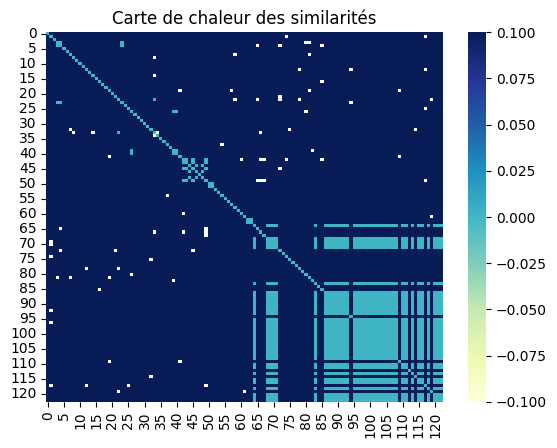

In [45]:
import seaborn as sns

# Créer une carte de chaleur en utilisant les données de la matrice de similarité
sns.heatmap(distance_matrix, cmap='YlGnBu')
plt.title('Carte de chaleur des similarités')
plt.show()


# DOUALA

In [ ]:
df_douala = pd.read_csv('Douala/CML_Douala/L1_172.22.249.1P3.2-172.22.249.3P3.1_71A-B.csv', sep=';', parse_dates=['datetime'])

In [ ]:
df_douala.head()

,datetime,direction,unique_link_id,length,frequency,TSL_min,TSL_mean,TSL_max,RSL_min,RSL_mean,RSL_max,Rgage,gage,dist_lnk_gage,link_name,calc_coeff_a,calc_coeff_b
0,2018-06-06 00:05:00,71 A-B,172.22.249.1P3.2-172.22.249.3P3.1,1.68,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lycee_NYALLA,0.952724,10G_MPR_NDOGPASSI_2 - MPR_LOGBABA-CAMTEL,0.0473,1.1022
1,2018-06-06 00:20:00,71 A-B,172.22.249.1P3.2-172.22.249.3P3.1,1.68,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lycee_NYALLA,0.952724,10G_MPR_NDOGPASSI_2 - MPR_LOGBABA-CAMTEL,0.0473,1.1022
2,2018-06-06 00:35:00,71 A-B,172.22.249.1P3.2-172.22.249.3P3.1,1.68,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lycee_NYALLA,0.952724,10G_MPR_NDOGPASSI_2 - MPR_LOGBABA-CAMTEL,0.0473,1.1022
3,2018-06-06 00:50:00,71 A-B,172.22.249.1P3.2-172.22.249.3P3.1,1.68,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lycee_NYALLA,0.952724,10G_MPR_NDOGPASSI_2 - MPR_LOGBABA-CAMTEL,0.0473,1.1022
4,2018-06-06 01:05:00,71 A-B,172.22.249.1P3.2-172.22.249.3P3.1,1.68,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lycee_NYALLA,0.952724,10G_MPR_NDOGPASSI_2 - MPR_LOGBABA-CAMTEL,0.0473,1.1022


In [ ]:
df_douala.dropna(inplace=True)
df_douala.head()

,datetime,direction,unique_link_id,length,frequency,TSL_min,TSL_mean,TSL_max,RSL_min,RSL_mean,RSL_max,Rgage,gage,dist_lnk_gage,link_name,calc_coeff_a,calc_coeff_b
14106,2019-01-24 22:35:00,71 A-B,172.22.249.1P3.2-172.22.249.3P3.1,1.68,14.5,20.0,20.0,20.0,-37.0,-36.8,-36.6,0.0,Lycee_NYALLA,0.952724,10G_MPR_NDOGPASSI_2 - MPR_LOGBABA-CAMTEL,0.0473,1.1022
14107,2019-01-24 22:50:00,71 A-B,172.22.249.1P3.2-172.22.249.3P3.1,1.68,14.5,20.0,20.0,20.0,-37.1,-36.8,-36.6,0.0,Lycee_NYALLA,0.952724,10G_MPR_NDOGPASSI_2 - MPR_LOGBABA-CAMTEL,0.0473,1.1022
14108,2019-01-24 23:05:00,71 A-B,172.22.249.1P3.2-172.22.249.3P3.1,1.68,14.5,20.0,20.0,20.0,-37.1,-36.9,-36.7,0.0,Lycee_NYALLA,0.952724,10G_MPR_NDOGPASSI_2 - MPR_LOGBABA-CAMTEL,0.0473,1.1022
14109,2019-01-24 23:20:00,71 A-B,172.22.249.1P3.2-172.22.249.3P3.1,1.68,14.5,20.0,20.0,20.0,-37.1,-36.9,-36.7,0.0,Lycee_NYALLA,0.952724,10G_MPR_NDOGPASSI_2 - MPR_LOGBABA-CAMTEL,0.0473,1.1022
14110,2019-01-24 23:35:00,71 A-B,172.22.249.1P3.2-172.22.249.3P3.1,1.68,14.5,20.0,20.0,20.0,-37.2,-36.8,-36.6,0.0,Lycee_NYALLA,0.952724,10G_MPR_NDOGPASSI_2 - MPR_LOGBABA-CAMTEL,0.0473,1.1022


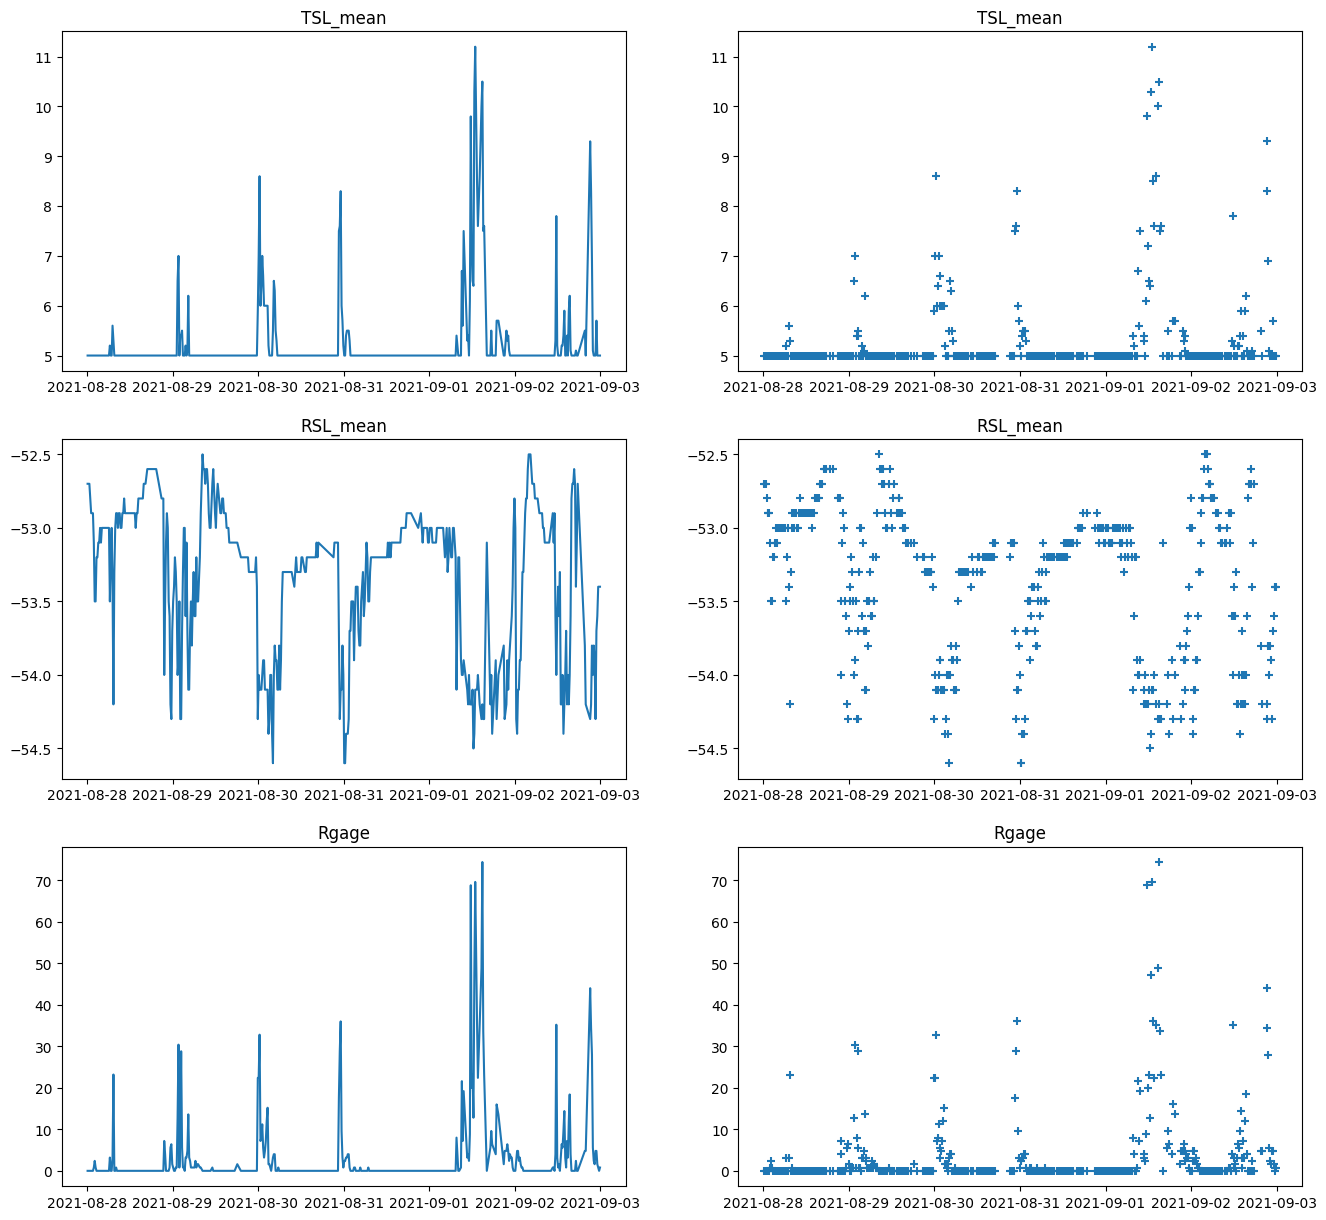

In [ ]:
df_ = df[['TSL_mean', 'RSL_mean', 'Rgage']]
fig, axs = plt.subplots(len(df_.columns), 2, figsize=(16, 5 * len(df_.columns)))

for i, col in enumerate(df_.columns):
    axs[i, 0].plot(df_[col])
    axs[i, 0].set_title(col)
    axs[i, 1].scatter(df.index, df_[col], marker='+')
    axs[i, 1].set_title(col)

plt.show()
